In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import torch
from torch import optim, nn
from math import exp

import numpy as np

from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image
from auto_encoder2 import PAutoE

device = "cuda"

pimages = load_dataset().to(device)

In [2]:
T = 30
beta = torch.linspace(10e-4, 0.05, T)

alpha = 1 - beta

alpha_ = torch.zeros(T)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_

tensor([0.9990, 0.9963, 0.9919, 0.9859, 0.9783, 0.9690, 0.9582, 0.9460, 0.9322,
        0.9171, 0.9007, 0.8831, 0.8643, 0.8444, 0.8236, 0.8019, 0.7794, 0.7563,
        0.7325, 0.7083, 0.6836, 0.6587, 0.6335, 0.6083, 0.5830, 0.5578, 0.5327,
        0.5079, 0.4834, 0.4592])

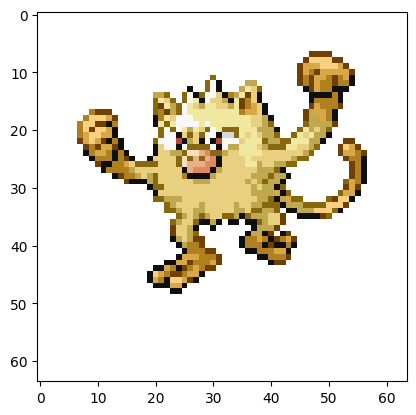

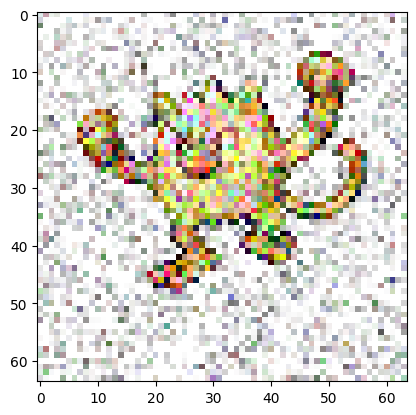

In [3]:
t = 15
x0 = pimages[0][55]

z = torch.randn(x0.shape).to(device)
xt = x0 * torch.sqrt(alpha_[t]) + z * torch.sqrt(1-alpha_[t])

plot_image(x0)
plot_image(xt)

In [4]:
for t in range(T):

    print(f"t = {t}")

    model = PAutoE(4, 4).to(device)

    loss_func = nn.MSELoss()    
    optimizer = optim.SGD(model.parameters(), lr=5e-2)
        
    pbar = tqdm(range(10001))
    def closure():
        optimizer.zero_grad()

        source = randint(0, 2)
        batch = torch.randperm(385)[:4]
        x0 = pimages[source][batch]

        z = torch.randn(x0.shape, device=device)
        xt = x0 * torch.sqrt(alpha_[t]) + z * torch.sqrt(1-alpha_[t])
        
        mu = model(xt)

        # Calculate the loss between the result and the noise
        loss = loss_func(mu, x0)
        loss.backward()
        
        pbar.set_description(f"%.8f" % loss)
        
        return loss
            
    model.train()
    for j in pbar:
        optimizer.step(closure)

    script = torch.jit.script(model)
    script.save(f"./model_{t}.pt")

t = 0


0.00295379: 100%|████████████████████████████████████████████████| 10001/10001 [02:14<00:00, 74.37it/s]


t = 1


0.00313568: 100%|████████████████████████████████████████████████| 10001/10001 [02:15<00:00, 73.89it/s]


t = 2


0.00336927: 100%|████████████████████████████████████████████████| 10001/10001 [02:15<00:00, 73.92it/s]


t = 3


0.00411199: 100%|████████████████████████████████████████████████| 10001/10001 [02:15<00:00, 73.89it/s]


t = 4


0.00563724: 100%|████████████████████████████████████████████████| 10001/10001 [02:15<00:00, 73.59it/s]


t = 5


0.00295704: 100%|████████████████████████████████████████████████| 10001/10001 [02:16<00:00, 73.26it/s]


t = 6


0.01039501: 100%|████████████████████████████████████████████████| 10001/10001 [02:16<00:00, 73.35it/s]


t = 7


0.00959530: 100%|████████████████████████████████████████████████| 10001/10001 [02:16<00:00, 73.19it/s]


t = 8


0.00899080: 100%|████████████████████████████████████████████████| 10001/10001 [02:16<00:00, 73.04it/s]


t = 9


0.00959316: 100%|████████████████████████████████████████████████| 10001/10001 [02:16<00:00, 73.12it/s]


t = 10


0.01212774: 100%|████████████████████████████████████████████████| 10001/10001 [02:17<00:00, 72.93it/s]


t = 11


0.01184813: 100%|████████████████████████████████████████████████| 10001/10001 [02:16<00:00, 73.05it/s]


t = 12


0.00731751: 100%|████████████████████████████████████████████████| 10001/10001 [02:16<00:00, 73.17it/s]


t = 13


0.01062581: 100%|████████████████████████████████████████████████| 10001/10001 [02:16<00:00, 73.48it/s]


t = 14


0.02012175: 100%|████████████████████████████████████████████████| 10001/10001 [02:17<00:00, 72.98it/s]


t = 15


0.01077728: 100%|████████████████████████████████████████████████| 10001/10001 [02:16<00:00, 73.12it/s]


t = 16


0.02434733: 100%|████████████████████████████████████████████████| 10001/10001 [02:17<00:00, 72.98it/s]


t = 17


0.02279637: 100%|████████████████████████████████████████████████| 10001/10001 [02:17<00:00, 72.99it/s]


t = 18


0.02376979: 100%|████████████████████████████████████████████████| 10001/10001 [02:16<00:00, 73.15it/s]


t = 19


0.02263099: 100%|████████████████████████████████████████████████| 10001/10001 [02:15<00:00, 73.74it/s]


t = 20


0.01546244: 100%|████████████████████████████████████████████████| 10001/10001 [02:15<00:00, 73.68it/s]


t = 21


0.02933777: 100%|████████████████████████████████████████████████| 10001/10001 [02:16<00:00, 73.20it/s]


t = 22


0.03091628: 100%|████████████████████████████████████████████████| 10001/10001 [02:16<00:00, 73.18it/s]


t = 23


0.03273378: 100%|████████████████████████████████████████████████| 10001/10001 [02:16<00:00, 73.35it/s]


t = 24


0.03024946: 100%|████████████████████████████████████████████████| 10001/10001 [02:15<00:00, 73.74it/s]


t = 25


0.02895163: 100%|████████████████████████████████████████████████| 10001/10001 [02:15<00:00, 73.74it/s]


t = 26


0.03786689: 100%|████████████████████████████████████████████████| 10001/10001 [02:15<00:00, 73.63it/s]


t = 27


0.03509897: 100%|████████████████████████████████████████████████| 10001/10001 [02:15<00:00, 73.69it/s]


t = 28


0.04577690: 100%|████████████████████████████████████████████████| 10001/10001 [02:14<00:00, 74.12it/s]


t = 29


0.02698112: 100%|████████████████████████████████████████████████| 10001/10001 [02:14<00:00, 74.31it/s]
